In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/testing/gymming/src


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from train_model import load_model
from concepts import concept_instances
from utils import plot_obs, prepare_folders

In [144]:
# TODO: transform activation as done in image sorting
def similarity(activation, cav):
    np_activation = activation.detach().cpu().numpy()
    np_cav = cav.detach().cpu().numpy()
    return np_activation.dot(np_cav.T) / (np.linalg.norm(np_activation) * np.linalg.norm(np_cav))

def hook_fn(m, i, o):
    global activation
    if len(o.shape) > 1:
        activation = o.flatten(start_dim=1)
    else:
        activation = o

In [145]:
concept = concept_instances[2]
layer = 3
learning_rate = 1
inp_shape = (1, 4, 84, 84)

cos = nn.CosineSimilarity(dim=1) # TODO: transform activation as done in image sorting
mse = nn.MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_network = load_model("../runs/20230914-224528/models/model_9899999.pt").to(device)

q_network.network[layer].register_forward_hook(hook_fn)
cav = concept.load_cav(layer)
cav = torch.from_numpy(cav).unsqueeze(0).to(device)

print(cav.shape)
print(concept.name)

torch.Size([1, 5184])
last life


In [146]:
inp = torch.zeros(inp_shape, requires_grad=True).to(device) # black image
'''
inp = torch.randn(inp_shape)
inp = (inp * 255.0 + 255.0) / 2.0
inp = inp.to(device)
inp.requires_grad = True
'''
inp.retain_grad()
print(inp.shape)

torch.Size([1, 4, 84, 84])


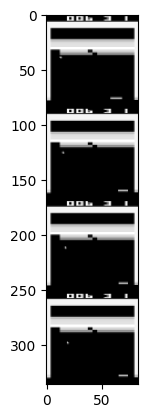

torch.Size([1, 4, 84, 84])


In [147]:
example = concept.get_absence_observations()[0]
example = torch.from_numpy(example).unsqueeze(0).to(device).float()
example.requires_grad = True
example.retain_grad()
plot_obs(example)
print(example.shape)

-0.0008448570151813328
[[0.05881154]]


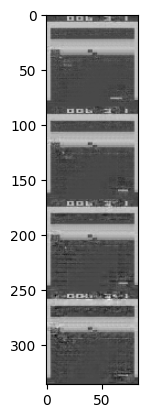

In [154]:
inp = example
for _ in range(5000):
    q_network(inp)
    #loss = cos(activation, cav)
    loss = -mse(activation, cav)
    loss.backward()
    inp.data = inp.data + learning_rate * inp.grad.data
    
print(loss.item())
print(similarity(activation, cav))
plot_obs(inp)

### DeepDream of highest Q-value

In [149]:
inp2 = torch.randn(inp_shape)
inp2 = (inp2 * 255.0 + 255.0) / 2.0
inp2 = inp2.to(device)
inp2.requires_grad = True
#inp2 = torch.zeros(inp2_shape, requires_grad=True).to(device) # black image
inp2.retain_grad()
print(inp2.shape)

torch.Size([1, 4, 84, 84])


741805.375


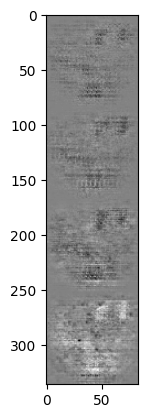

In [158]:
for _ in range(5000):
    output = q_network(inp2)
    #loss = cos(activation, cav)
    #loss = -mse(activation, cav)
    #loss = output.max()
    loss = output.mean()
    #loss = output.min()
    loss.backward()
    inp2.data = inp2.data + learning_rate * inp2.grad.data
    
print(loss.item())
plot_obs(inp2)